<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Training" data-toc-modified-id="Sample-Training-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Training</a></span></li><li><span><a href="#Process-Prediction-Model" data-toc-modified-id="Process-Prediction-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Process Prediction Model</a></span></li><li><span><a href="#Pipeline-Runner" data-toc-modified-id="Pipeline-Runner-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pipeline Runner</a></span></li></ul></div>

In [1]:
# default_exp pipeline

Pipeline
===



In [2]:
#hide

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

%matplotlib inline

In [3]:
#export
from mppn.imports import *
from mppn.preprocessing import *
import pickle

## Sample Training

This section introduces a sample training, whith an simple recurrent pytorch model on the task next activity prediction.

In [4]:
log=import_log(EventLogs.Helpdesk)

In [5]:
col='resource'
o=PPObj(log,procs=Categorify(),cat_names=col,y_names=col,splits=split_traces(log))
o.show()

#traces: 4580 #events: 21348


,resource
trace_id,
Case250,5
Case250,5
Case250,8


In [6]:
dls=o.get_dls()
xb,yb=dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 64]), torch.Size([64]))

In [7]:
xb[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 12])

In [8]:
len(o.procs.categorify[col])

23

In [9]:
#export
class RNNwEmbedding(torch.nn.Module) :
    def __init__(self,o) :
        super().__init__()
        vocab_size=len(o.procs.categorify[o.y_names[0]])
        emb_size = int(sqrt(vocab_size))+1
        hidden_six = 20
        self.emb = nn.Embedding(vocab_size,emb_size)

        self.rnn = nn.RNN(emb_size, hidden_six, batch_first=True, num_layers=2)

        self.linear = nn.Linear(hidden_six, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x,_ = self.rnn(x)
        x = x[:,-1]
        x = self.linear(x)
        x = F.softmax(x,dim=1)
        return x

In [10]:
m=RNNwEmbedding(o)


In [11]:
p=m(xb)

In [12]:
#export
class HideOutput:
    'A utility function that hides all outputs in a context'
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [13]:
#export
def training_loop(learn,epoch,print_output,lr_find):
    '''
    Basic training loop that uses learning rate finder and one cycle training. 
    See fastai docs for more information
    '''
    if lr_find:
        lr=np.median([learn.lr_find(show_plot=print_output)[0] for i in range(5)])
        learn.fit_one_cycle(epoch,float(lr))
    else: learn.fit(epoch,0.01)

In [14]:
#export
def train_validate(dls,m,metrics=accuracy,loss=F.cross_entropy,epoch=20,print_output=True,model_dir=".",lr_find=True,
                   output_index=1,patience=3,min_delta=0.005,show_plot=True,store_path='tmp',model_name='.model'):
    '''
    Trains a model on the training set with early stopping based on the validation loss.
    Afterwards, applies it to the test set.
    '''
    cbs = [CudaCallback,
      EarlyStoppingCallback(monitor='valid_loss',min_delta=min_delta, patience=patience),
      SaveModelCallback(fname=model_name)
      ]
    learn=Learner(dls, m, path=store_path, model_dir=model_dir, loss_func=loss ,metrics=metrics,cbs=cbs)

    if print_output:
        training_loop(learn,epoch,show_plot,lr_find=lr_find)
        return learn.validate(dl=dls[2])[output_index]
    else:
        with HideOutput(),learn.no_bar(),learn.no_logging():
            training_loop(learn,epoch,show_plot,lr_find=lr_find)
            return learn.validate(dl=dls[2])[output_index]

epoch,train_loss,valid_loss,accuracy,time
0,2.048646,2.020072,0.795227,00:01
1,2.043587,2.021096,0.795997,00:01
2,2.037191,2.016666,0.799846,00:01
3,2.041627,2.018199,0.798306,00:01


Better model found at epoch 0 with valid_loss value: 2.0200722217559814.
Better model found at epoch 2 with valid_loss value: 2.0166661739349365.
No improvement since epoch 0: early stopping


Better model found at epoch 0 with valid_loss value: 0.7875000238418579.


0.7875000238418579

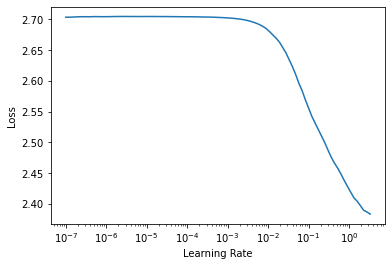

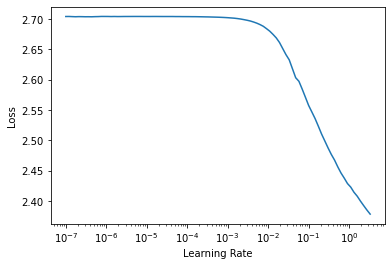

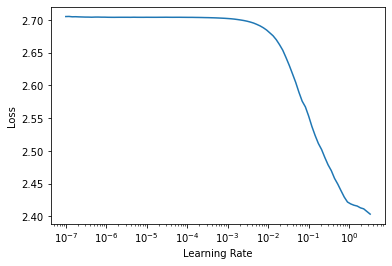

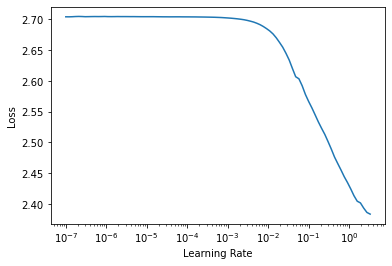

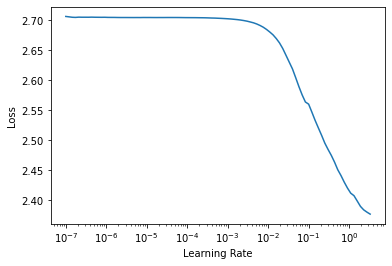

In [15]:
cols,outcome='activity',False
o=PPObj(log,procs=Categorify(),cat_names=cols,y_names=cols,splits=split_traces(log))
dls=o.get_dls(outcome=outcome,windows=partial(subsequences_fast,min_ws=0))
m=RNNwEmbedding(o)
train_validate(dls,m,epoch=5)

## Process Prediction Model

The `PPModel` class creates multiple prediction models for next-step prediction, next-resource prediction, remaining time prediction, etc. based on a pytorch model architecture.

In [16]:
#export

# Todo: Add Logging
class PPModel():

    def __init__(self,log,ds_name,splits,store=None,bs=64,print_output=False,patience=3,min_delta=0.005,
                 attr_dict=None,windows=partial(subsequences_fast,min_ws=0),epoch=20,sample=False,
                 train_validate=train_validate):
        store_attr('log,ds_name,splits,attr_dict,windows,epoch,bs,print_output,min_delta,patience,store')
        self.lr_find=True
        if sample:
            self.lr_find=False
            traces=self.splits[0]
            self.splits=traces[:60],traces[60:80],traces[80:100]
            self.bs=64
            self.epoch=1

    def evaluate(self):
        if not self.print_output:
            with HideOutput(): return self.__evaluate()
        else: return self.__evaluate()
    def __evaluate(self):
        print(self.ds_name,self.get_name())
        self.setup()

        print('next_step_prediction')
        nsp=self.next_step_prediction()

        print('next_resource_prediction')
        nrp=self.next_resource_prediction()

        print('last_resource_prediction')
        lrp=self.last_resource_prediction()

        print('outcome_prediction')
        op=self.outcome_prediction()

        print('duration_to_next_event_prediction')
        dtnep=self.duration_to_next_event_prediction()

        print('duration_to_end_prediction')
        dtep=self.duration_to_end_prediction()

        print('activity_suffix_prediction')
        asp=self.activity_suffix_prediction()

        print('resource_suffix_prediction')
        rsp=self.resource_suffix_prediction()

        return nsp, nrp, lrp, op, dtnep, dtep, asp, rsp

    def _train_validate(self,dls,m,metrics=accuracy,loss=F.cross_entropy,output_index=1):
        store,model_name='tmp','.model'
        if self.store:
            ins_stack=inspect.stack()
            model_name=str(ins_stack[2][3]) if str(ins_stack[2][3])!='__evaluate' else str(ins_stack[1][3])
            store=self.store/self.ds_name/self.get_name()
        return train_validate(dls,m,metrics=metrics,loss=loss,output_index=output_index, #Only change these
                              epoch=self.epoch,print_output=self.print_output,patience=self.patience,
                              min_delta=self.min_delta,show_plot=False,store_path=store,model_name=model_name,
                              lr_find=self.lr_find)
    def setup(self): pass
    def get_name(self): return self.__class__.__name__.replace('PPM_',"")
    def next_step_prediction(self): pass
    def next_resource_prediction(self): pass
    def last_resource_prediction(self): pass
    def outcome_prediction(self): pass
    def duration_to_next_event_prediction(self): pass
    def duration_to_end_prediction(self): pass
    def activity_suffix_prediction(self): pass
    def resource_suffix_prediction(self): pass

In [17]:
#export
def get_ds_name(url): return(url.stem) # Utility function, that gets the name of a dataset

In [18]:
#export
class PPM_RNNwEmbedding(PPModel):
    'Sampe PPM based on RNNwEmbedding'
    model=RNNwEmbedding

    def next_step_prediction(self,outcome=False,col='activity'):
        o=PPObj(self.log,procs=Categorify(),cat_names=col,y_names=col,splits=self.splits)
        dls=o.get_dls(outcome=outcome,bs=self.bs,windows=self.windows)
        m=self.model(o)
        return self._train_validate(dls,m)

    def next_resource_prediction(self): return self.next_step_prediction(col='resource')
    def last_resource_prediction(self): return self.next_step_prediction(col='resource',outcome=True)
    def outcome_prediction(self): return self.next_step_prediction(outcome=True)

In [19]:
path=EventLogs.Helpdesk
log=import_log(path)
ds_name=get_ds_name(path)
splits=split_traces(log)

In [20]:
ppm=PPM_RNNwEmbedding(log,ds_name,splits,epoch=1)

In [21]:
ppm.next_step_prediction()

0.7875000238418579

## Pipeline Runner

A runner function for `PPModel`. Runs multiple prediction models on various datasets for several runs. Writes the results to a dataframe and stores it on disk in the `./tmp` folder. Stores the splits, the trained models, and the results. Accepts multiple parameters.

In [22]:
#export
from datetime import datetime
import inspect
from tqdm.notebook import tqdm

In [23]:
#export
class Performance_Statistic():
    'Creates a results dataframe, that shows the performance of all models on all datasets on all tasks.'
    def __init__(self):
        self.df = pd.DataFrame(
        columns=['Dataset', 'Model', 'Next Step', 'Next Resource', 'Last Resource', 'Outcome',
                'Next relative Timestamp', 'Duration to Outcome', 'Activity Suffix', 'Resource Suffix'])
    def update(self,model_performance): self.df.loc[len(self.df)] = model_performance
    def to_df(self):
        return self.df

In [24]:
#export
def _store_path(results_dir=Path('./tmp')):
    'Creates a new folder to store results'
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H:%M:%S")
    results_dir=results_dir/current_time
    results_dir.mkdir()
    return results_dir

In [25]:
#export
@delegates(PPModel)
def runner(dataset_urls,ppm_classes,store=True,runs=1,sample=False,validation_seed=None,test_seed=42,tqdm=tqdm,
           **kwargs):
    store_path= _store_path() if store else None
    '''
    Runs a number of process prediction models PPModel on a number of datasets for multiple runs.
    Stores results in ./tmp folder.
    '''
    i=0
    results=[]
    for r in tqdm(range(runs),desc='Runs'):
        performance_statistic = Performance_Statistic()
        db=tqdm(range(len(dataset_urls)),leave=False)
        for i in db:
            db.set_description(get_ds_name(dataset_urls[i]))
            ds= dataset_urls[i]
            log=import_log(ds)
            ds_name=get_ds_name(ds)
            splits=split_traces(log,ds_name,validation_seed=validation_seed,test_seed=test_seed)
            if store:
                with open(store_path/f'run{r}_{ds_name}_splits.pickle', "wb") as output_file:
                    pickle.dump(splits, output_file)
            mb=tqdm(range(len(ppm_classes)),leave=False)
            for j in mb:
                mb.set_description(ppm_classes[j].__name__.replace('PPM_',""))
                ppm_class=ppm_classes[j]
                model_path=store_path/'models'/f"run{r}" if store else None
                model=ppm_class(log,ds_name,splits,store=model_path,sample=sample,**kwargs)
                model_performance = model.evaluate()
                model_performance = [ds_name, model.get_name(),*model_performance]
                performance_statistic.update(model_performance)
                [ds_name, model.get_name(),*model_performance]

        df = performance_statistic.to_df()
        results.append(df)
        if store: df.to_csv(store_path/f"run_{r}_results.csv")
    return results if len(results)>1 else results[0]

This sample shows how to use the runner function:

In [26]:
%%time
datasets=[EventLogs.Helpdesk,EventLogs.BPIC_13_CP]
ppms=[PPM_RNNwEmbedding,PPM_RNNwEmbedding]
res=runner(datasets,ppms,epoch=1,windows=partial(subsequences_fast,min_ws=0),store=True,print_output=False,
           sample=True,runs=2)


Runs:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 3.87 s, sys: 23.6 s, total: 27.4 s
Wall time: 28.7 s
